In [1]:
# === STEP 1: Peek at columns & basic structure (no assumptions) ===
import pandas as pd

# 👉 Change this to your actual file path
CSV_PATH = "bbc_news.csv"

# Read safely without inferring mixed dtypes
df = pd.read_csv(CSV_PATH, low_memory=False)

print("=== Shape ===")
print(df.shape)

print("\n=== Column Names ===")
print(df.columns.tolist())

print("\n=== dtypes ===")
print(df.dtypes)

print("\n=== .info() ===")
print(df.info())

print("\n=== First 3 rows ===")
print(df.head(3))

print("\n=== Null counts per column ===")
print(df.isna().sum().sort_values(ascending=False))


=== Shape ===
(42115, 5)

=== Column Names ===
['title', 'pubDate', 'guid', 'link', 'description']

=== dtypes ===
title          object
pubDate        object
guid           object
link           object
description    object
dtype: object

=== .info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42115 entries, 0 to 42114
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        42115 non-null  object
 1   pubDate      42115 non-null  object
 2   guid         42115 non-null  object
 3   link         42115 non-null  object
 4   description  42115 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB
None

=== First 3 rows ===
                                               title  \
0  Ukraine: Angry Zelensky vows to punish Russian...   
1  War in Ukraine: Taking cover in a town under a...   
2         Ukraine war 'catastrophic for global food'   

                         pubDate  \
0  Mon, 07 Mar 2022 0

In [2]:
# Keep only the text-bearing columns
df = df[["title", "description"]].copy()

# Combine title and description into one column
df["text"] = df["title"].astype(str) + " " + df["description"].astype(str)

# Drop if somehow empty after merge
df = df[df["text"].str.strip().str.len() > 0]

print("=== Shape after cleaning ===")
print(df.shape)

print("\n=== Sample combined texts ===")
for i in range(3):
    print(f"\n--- Sample {i+1} ---\n{df.iloc[i]['text'][:300]}...")


=== Shape after cleaning ===
(42115, 3)

=== Sample combined texts ===

--- Sample 1 ---
Ukraine: Angry Zelensky vows to punish Russian atrocities The Ukrainian president says the country will not forgive or forget those who murder its civilians....

--- Sample 2 ---
War in Ukraine: Taking cover in a town under attack Jeremy Bowen was on the frontline in Irpin, as residents came under Russian fire while trying to flee....

--- Sample 3 ---
Ukraine war 'catastrophic for global food' One of the world's biggest fertiliser firms says the conflict could deliver a shock to food supplies....


In [3]:
# Re-read the CSV so we can use the 'link' column for labeling (keeps things clean)
import pandas as pd
import re

CSV_PATH = "/content/bbc_news.csv"   # <-- adjust if needed
raw = pd.read_csv(CSV_PATH, low_memory=False)

# Keep what we need
df = raw[["title", "description", "link"]].copy()
df["text"] = (df["title"].astype(str) + " " + df["description"].astype(str)).str.strip()

# --- Extract section from the URL like:
# https://www.bbc.co.uk/news/world-europe-60638042  -> "world"
# https://www.bbc.co.uk/news/business-60623941      -> "business"
# https://www.bbc.co.uk/news/technology-...         -> "technology"
# https://www.bbc.co.uk/sport/football/...          -> "sport"
def extract_section(url: str) -> str:
    if not isinstance(url, str):
        return "unknown"
    url = url.lower()
    # Prefer the path right after domain
    m = re.search(r"bbc\.(?:co\.uk|com)/(news|sport|[^/]+)/([^/?#]+)?", url)
    if not m:
        return "unknown"
    root = m.group(1)  # e.g., "news" or "sport"
    rest = m.group(2) or ""
    # If root is 'sport', that's already a solid label
    if root == "sport":
        return "sport"
    # If root is 'news', try to get the first token from 'rest' (e.g., 'world-europe-60638042' -> 'world')
    if root == "news":
        # grab first token before '-' or '/'
        token = re.split(r"[-/]", rest)[0]
        # sometimes rest is numeric id (no token)
        if token and not token.isdigit():
            return token
        else:
            return "news"
    # fallback
    return root

df["section_raw"] = df["link"].apply(extract_section)

# Collapse similar sections to canonical topic labels
MAP = {
    "world": "world",
    "uk": "politics", "politics": "politics",
    "business": "business", "economy": "business", "work": "business", "money": "business",
    "technology": "tech", "tech": "tech", "science": "tech",
    "entertainment": "entertainment", "arts": "entertainment",
    "entertainment_and_arts": "entertainment", "culture": "entertainment",
    "sport": "sport",
    "news": "world",  # plain /news/ → often general/world
}

def canon_label(x: str) -> str:
    x = (x or "").strip().lower()
    return MAP.get(x, x if x in {"world","business","tech","sport","entertainment","politics"} else "other")

df["label"] = df["section_raw"].apply(canon_label)

# Keep only rows with usable text
df = df[df["text"].str.len() > 0].copy()

print("=== Derived label distribution (top 20) ===")
print(df["label"].value_counts().head(20))

print("\n=== Sample rows per derived label ===")
for lab in df["label"].value_counts().head(6).index:
    sub = df[df["label"] == lab].head(2)
    print(f"\n--- {lab} ---")
    for _, r in sub.iterrows():
        print(r["title"])


=== Derived label distribution (top 20) ===
label
other            9946
politics         9665
world            8608
sport            8395
business         2646
entertainment    1863
tech              992
Name: count, dtype: int64

=== Sample rows per derived label ===

--- other ---
The young Ukrainians battling pro-Russian trolls
The Papers: 'Running for their lives' as terror 'rains down'

--- politics ---
Manchester Arena bombing: Saffie Roussos's parents on hearing the truth
Ukraine war: PM to hold talks with world leaders on further sanctions

--- world ---
Ukraine: Angry Zelensky vows to punish Russian atrocities
War in Ukraine: Taking cover in a town under attack

--- sport ---
Russian gymnast investigated for wearing pro-war symbol on podium next to Ukrainian
'Either they're not good enough or they don't care' - pundits react to Man Utd's derby display

--- business ---
Ukraine war 'catastrophic for global food'
Ukraine conflict: Oil price soars to highest level since 2008

---

In [4]:
# We continue from the df that already has: ['title','description','link','text','section_raw','label']

# 1) Keep only the six clear BBC topics
TARGETS = ["world", "politics", "sport", "business", "entertainment", "tech"]
df_clf = df[df["label"].isin(TARGETS)].copy()

# 2) Basic sanity
print("=== Shape after keeping clear topics ===")
print(df_clf.shape)

print("\n=== Class counts ===")
print(df_clf["label"].value_counts())

print("\n=== Class percentages ===")
print((df_clf["label"].value_counts(normalize=True)*100).round(2))

print("\n=== Sample title per class (quick sniff test) ===")
for lab in TARGETS:
    ex = df_clf.loc[df_clf["label"]==lab, "title"].head(2).tolist()
    print(f"\n-- {lab} --")
    for t in ex:
        print(t)


=== Shape after keeping clear topics ===
(32169, 6)

=== Class counts ===
label
politics         9665
world            8608
sport            8395
business         2646
entertainment    1863
tech              992
Name: count, dtype: int64

=== Class percentages ===
label
politics         30.04
world            26.76
sport            26.10
business          8.23
entertainment     5.79
tech              3.08
Name: proportion, dtype: float64

=== Sample title per class (quick sniff test) ===

-- world --
Ukraine: Angry Zelensky vows to punish Russian atrocities
War in Ukraine: Taking cover in a town under attack

-- politics --
Manchester Arena bombing: Saffie Roussos's parents on hearing the truth
Ukraine war: PM to hold talks with world leaders on further sanctions

-- sport --
Russian gymnast investigated for wearing pro-war symbol on podium next to Ukrainian
'Either they're not good enough or they don't care' - pundits react to Man Utd's derby display

-- business --
Ukraine war 'catas

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8477
Macro F1: 0.7883 | Weighted F1: 0.8497

=== Classification Report ===
               precision    recall  f1-score   support

     business      0.756     0.824     0.788       529
entertainment      0.660     0.858     0.746       373
     politics      0.855     0.784     0.818      1933
        sport      0.952     0.955     0.953      1679
         tech      0.500     0.652     0.566       198
        world      0.875     0.843     0.859      1722

     accuracy                          0.848      6434
    macro avg      0.766     0.819     0.788      6434
 weighted avg      0.855     0.848     0.850      6434



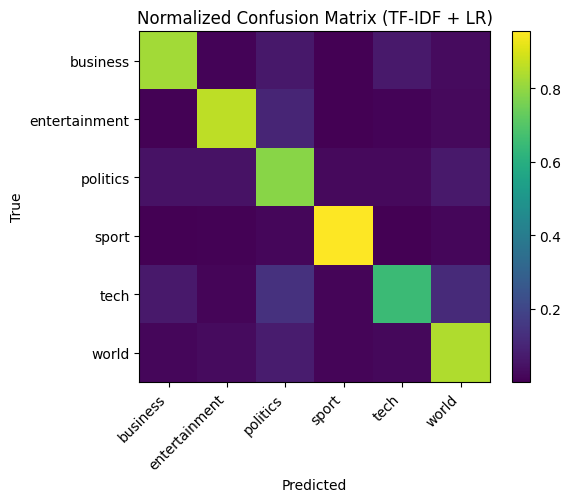

In [5]:
# === STEP 5: Baseline TF-IDF + Logistic Regression ===
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# We continue from df_clf created earlier (columns include: text, label)
assert "text" in df_clf.columns and "label" in df_clf.columns, "df_clf must have 'text' and 'label'."

X = df_clf["text"].astype(str).values
y = df_clf["label"].astype(str).values

# Stratified split to preserve class proportions
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF with uni+bi-grams; light filtering; English stopwords
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    stop_words="english",
    max_features=100_000
)

Xtr = tfidf.fit_transform(X_train)
Xva = tfidf.transform(X_val)

# Logistic Regression baseline (balanced handles class imbalance)
clf = LogisticRegression(
    max_iter=200,
    class_weight="balanced",
    n_jobs=None,            # (param not used for lbfgs; left explicit for clarity)
    solver="lbfgs",
    multi_class="auto"
)
clf.fit(Xtr, y_train)

# Evaluate
pred = clf.predict(Xva)
acc  = accuracy_score(y_val, pred)
f1m  = f1_score(y_val, pred, average="macro")
f1w  = f1_score(y_val, pred, average="weighted")

print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1m:.4f} | Weighted F1: {f1w:.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_val, pred, digits=3))

# Confusion matrix (normalized by true class)
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, pred, labels=labels, normalize="true")

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Normalized Confusion Matrix (TF-IDF + LR)")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha="right")
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [6]:
# Uses existing 'tfidf' and 'clf' you just trained
import numpy as np
import pandas as pd

feature_names = np.array(tfidf.get_feature_names_out())
classes = clf.classes_                      # order matches clf.coef_ rows

def top_terms_per_class(coef_row, topk=20):
    idx = np.argsort(coef_row)[::-1][:topk]
    return pd.DataFrame({
        "term": feature_names[idx],
        "weight": coef_row[idx].round(4)
    })

for i, c in enumerate(classes):
    print(f"\n=== Top terms for class: {c} ===")
    display(top_terms_per_class(clf.coef_[i], topk=20))



=== Top terms for class: business ===


,term,weight
0,prices,4.9943
1,firms,4.7907
2,economy,4.0065
3,bank,3.9899
4,sales,3.8853
5,business,3.8772
6,rates,3.7842
7,energy,3.6570
8,money,3.6275
9,mortgage,3.5280



=== Top terms for class: entertainment ===


,term,weight
0,star,6.7019
1,film,5.7477
2,singer,5.1237
3,actor,4.8886
4,eurovision,4.8327
5,actress,4.6157
6,album,4.2101
7,tv,4.1433
8,stars,3.9792
9,awards,3.9065



=== Top terms for class: politics ===


,term,weight
0,wales,3.7160
1,tory,3.4892
2,labour,3.4692
3,scotland,3.3559
4,scottish,3.3515
5,police,3.3423
6,pm,2.9128
7,uk,2.8270
8,mp,2.7927
9,welsh,2.6747



=== Top terms for class: sport ===


,term,weight
0,england,7.1779
1,league,5.2939
2,win,5.1888
3,sport,4.8077
4,cup,4.4462
5,chelsea,4.0613
6,title,3.6177
7,championship,3.5318
8,open,3.5030
9,manager,3.4786



=== Top terms for class: tech ===


,term,weight
0,climate,6.5540
1,ai,5.4860
2,scientists,5.3129
3,twitter,3.7308
4,cyber,3.6052
5,researchers,3.5891
6,google,3.5867
7,apple,3.5097
8,sewage,3.4308
9,planet,3.4107



=== Top terms for class: world ===


,term,weight
0,president,4.4532
1,gaza,4.3642
2,trump,4.3477
3,ukraine,4.3099
4,india,3.9435
5,russia,3.9285
6,china,3.4529
7,israel,3.2792
8,russian,3.2368
9,indian,3.2165


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Accuracy: 0.8405
Macro F1: 0.7793 | Weighted F1: 0.8433

=== Classification Report (lemmatized TF-IDF) ===
               precision    recall  f1-score   support

     business      0.736     0.824     0.778       529
entertainment      0.624     0.869     0.726       373
     politics      0.858     0.762     0.807      1933
        sport      0.951     0.954     0.952      1679
         tech      0.480     0.662     0.556       198
        world      0.874     0.837     0.856      1722

     accuracy                          0.841      6434
    macro avg      0.754     0.818     0.779      6434
 weighted avg      0.852     0.841     0.843      6434



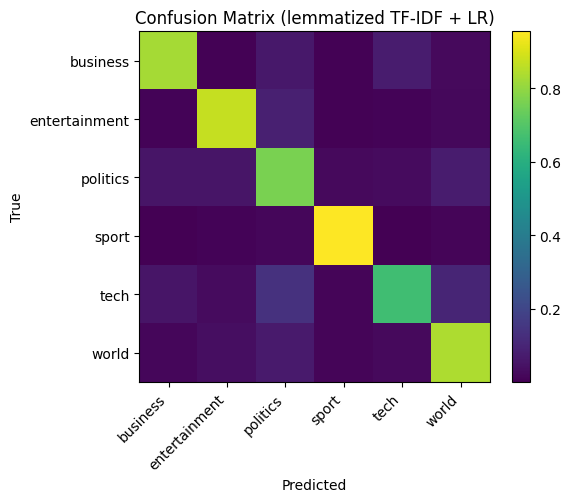

In [10]:
# === STEP 6B: Refit TF-IDF with lemmatization + cleanup, then retrain LR ===
import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Reuse X_train, X_val, y_train, y_val from the previous split
STOP = set(stopwords.words("english"))
LEM  = WordNetLemmatizer()

token_re = re.compile(r"[a-zA-Z]{2,}")  # alphabetic tokens of length >=2

def clean_lemma_analyzer(doc: str):
    # lowercase
    doc = doc.lower()
    # remove urls
    doc = re.sub(r"http\S+|www\.\S+", " ", doc)
    # tokenize by regex
    for tok in token_re.findall(doc):
        if tok in STOP:
            continue
        # lemmatize (noun first, then verb fallback)
        lemma = LEM.lemmatize(tok)
        lemma = LEM.lemmatize(lemma, "v")
        yield lemma

tfidf_lem = TfidfVectorizer(
    analyzer=clean_lemma_analyzer,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    max_features=120_000
)

Xtr2 = tfidf_lem.fit_transform(X_train)
Xva2 = tfidf_lem.transform(X_val)

clf2 = LogisticRegression(
    max_iter=250,
    class_weight="balanced",
    solver="lbfgs"
)
clf2.fit(Xtr2, y_train)

pred2 = clf2.predict(Xva2)
acc2  = accuracy_score(y_val, pred2)
f1m2  = f1_score(y_val, pred2, average="macro")
f1w2  = f1_score(y_val, pred2, average="weighted")

print(f"Accuracy: {acc2:.4f}")
print(f"Macro F1: {f1m2:.4f} | Weighted F1: {f1w2:.4f}\n")
print("=== Classification Report (lemmatized TF-IDF) ===")
print(classification_report(y_val, pred2, digits=3))

# Optional: quick confusion matrix
labels = sorted(np.unique(y_val))
cm2 = confusion_matrix(y_val, pred2, labels=labels, normalize="true")
plt.figure(figsize=(6,5))
plt.imshow(cm2, interpolation="nearest")
plt.title("Confusion Matrix (lemmatized TF-IDF + LR)")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha="right")
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [11]:
# === STEP 6C: Char TF-IDF + LR, then simple late-fusion with existing word TF-IDF model ===
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# We reuse: X_train, X_val, y_train, y_val, tfidf (word-level), clf (word-level), Xva from STEP 5
# Sanity checks:
assert 'tfidf' in globals() and 'clf' in globals(), "Run STEP 5 first to train the word TF-IDF model."
assert 'X_train' in globals() and 'X_val' in globals(), "Need X_train/X_val from earlier split."
assert 'Xva' in globals(), "Need Xva from STEP 5."

# 1) Char-level TF-IDF (tri- to penta-grams is a good sweet spot)
tfidf_char = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3,5),
    min_df=5,
    max_df=0.95,
    lowercase=True,
    max_features=200_000
)
Xtr_char = tfidf_char.fit_transform(X_train)
Xva_char = tfidf_char.transform(X_val)

# 2) Train Logistic Regression on char features
clf_char = LogisticRegression(
    max_iter=250,
    class_weight='balanced',
    solver='lbfgs',
    multi_class='auto'
)
clf_char.fit(Xtr_char, y_train)

# 3) Evaluate char-only
pred_char = clf_char.predict(Xva_char)
acc_c  = accuracy_score(y_val, pred_char)
f1m_c  = f1_score(y_val, pred_char, average='macro')
f1w_c  = f1_score(y_val, pred_char, average='weighted')
print("=== Char TF-IDF + LR ===")
print(f"Accuracy: {acc_c:.4f} | Macro F1: {f1m_c:.4f} | Weighted F1: {f1w_c:.4f}\n")

# 4) Simple late fusion: average predicted probabilities (word + char)
#    (If a class is missing from one model's classes_, align by class order)
classes = clf.classes_
proba_word = clf.predict_proba(Xva)  # (N, C) in order of clf.classes_
# Ensure char model class order matches:
assert np.array_equal(classes, clf_char.classes_), "Class orders differ; align before averaging."
proba_char = clf_char.predict_proba(Xva_char)

proba_ens = (proba_word + proba_char) / 2.0
pred_ens  = classes[proba_ens.argmax(axis=1)]

acc_e  = accuracy_score(y_val, pred_ens)
f1m_e  = f1_score(y_val, pred_ens, average='macro')
f1w_e  = f1_score(y_val, pred_ens, average='weighted')

print("=== Ensemble (word TF-IDF + char TF-IDF) ===")
print(f"Accuracy: {acc_e:.4f} | Macro F1: {f1m_e:.4f} | Weighted F1: {f1w_e:.4f}\n")

print("=== Classification Report (Ensemble) ===")
print(classification_report(y_val, pred_ens, digits=3))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Char TF-IDF + LR ===
Accuracy: 0.8438 | Macro F1: 0.7853 | Weighted F1: 0.8457

=== Ensemble (word TF-IDF + char TF-IDF) ===
Accuracy: 0.8527 | Macro F1: 0.7951 | Weighted F1: 0.8544

=== Classification Report (Ensemble) ===
               precision    recall  f1-score   support

     business      0.757     0.830     0.792       529
entertainment      0.651     0.863     0.742       373
     politics      0.860     0.789     0.823      1933
        sport      0.951     0.956     0.954      1679
         tech      0.542     0.657     0.594       198
        world      0.883     0.851     0.867      1722

     accuracy                          0.853      6434
    macro avg      0.774     0.824     0.795      6434
 weighted avg      0.860     0.853     0.854      6434



In [13]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 46.8 MB/s eta 0:00:00


In [14]:
# === STEP 7: Word2Vec (trained on your corpus) + Logistic Regression ===
import re, numpy as np
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Reuse X_train, X_val, y_train, y_val
STOP = set(stopwords.words("english"))
tok_re = re.compile(r"[A-Za-z]{2,}")

def tokenize(s):
    s = s.lower()
    return [t for t in tok_re.findall(s) if t not in STOP]

# Tokenize training corpus for Word2Vec
sentences = [tokenize(t) for t in X_train]

# Train a small Word2Vec (fast)
w2v = Word2Vec(
    sentences=sentences,
    vector_size=200,  # 100–300 is typical; 200 is a good middle
    window=5,
    min_count=3,
    workers=4,
    sg=1,            # skip-gram often better for semantics
    negative=10,
    epochs=5
)

# Helper: average word vectors for each doc
def doc_vector(doc_tokens, model, dim):
    vecs = [model.wv[w] for w in doc_tokens if w in model.wv]
    if not vecs:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vecs, axis=0)

dim = w2v.wv.vector_size
Xtr_w2v = np.vstack([doc_vector(tokenize(t), w2v, dim) for t in X_train])
Xva_w2v = np.vstack([doc_vector(tokenize(t), w2v, dim) for t in X_val])

# Classifier on averaged embeddings
clf_w2v = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    solver="lbfgs",
    multi_class="auto"
)
clf_w2v.fit(Xtr_w2v, y_train)

pred_w2v = clf_w2v.predict(Xva_w2v)
acc = accuracy_score(y_val, pred_w2v)
f1m = f1_score(y_val, pred_w2v, average="macro")
f1w = f1_score(y_val, pred_w2v, average="weighted")

print(f"Word2Vec AvgVec → LR | Acc: {acc:.4f} | Macro F1: {f1m:.4f} | Weighted F1: {f1w:.4f}\n")
print("=== Classification Report (Word2Vec) ===")
print(classification_report(y_val, pred_w2v, digits=3))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Word2Vec AvgVec → LR | Acc: 0.7703 | Macro F1: 0.6983 | Weighted F1: 0.7795

=== Classification Report (Word2Vec) ===
               precision    recall  f1-score   support

     business      0.657     0.733     0.693       529
entertainment      0.524     0.839     0.645       373
     politics      0.813     0.639     0.716      1933
        sport      0.948     0.940     0.944      1679
         tech      0.284     0.687     0.402       198
        world      0.825     0.757     0.790      1722

     accuracy                          0.770      6434
    macro avg      0.675     0.766     0.698      6434
 weighted avg      0.805     0.770     0.780      6434



In [15]:
# === STEP 8: Sentence-BERT embeddings + Logistic Regression ===
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

# Use a compact model to keep it fast
bert_model = SentenceTransformer("all-MiniLM-L6-v2")  # 384-dim sentence vectors

# Encode train/val texts
Xtr_bert = bert_model.encode(list(X_train), batch_size=64, show_progress_bar=True)
Xva_bert = bert_model.encode(list(X_val), batch_size=64, show_progress_bar=True)

clf_bert = LogisticRegression(max_iter=500, class_weight="balanced")
clf_bert.fit(Xtr_bert, y_train)

pred_bert = clf_bert.predict(Xva_bert)
accb = accuracy_score(y_val, pred_bert)
f1mb = f1_score(y_val, pred_bert, average="macro")
f1wb = f1_score(y_val, pred_bert, average="weighted")

print(f"BERT (MiniLM) → LR | Acc: {accb:.4f} | Macro F1: {f1mb:.4f} | Weighted F1: {f1wb:.4f}\n")
print("=== Classification Report (BERT embeddings) ===")
print(classification_report(y_val, pred_bert, digits=3))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/403 [00:00<?, ?it/s]

Batches:   0%|          | 0/101 [00:00<?, ?it/s]

BERT (MiniLM) → LR | Acc: 0.8001 | Macro F1: 0.7360 | Weighted F1: 0.8058

=== Classification Report (BERT embeddings) ===
               precision    recall  f1-score   support

     business      0.675     0.800     0.732       529
entertainment      0.565     0.869     0.685       373
     politics      0.853     0.681     0.757      1933
        sport      0.936     0.948     0.942      1679
         tech      0.366     0.727     0.487       198
        world      0.845     0.784     0.813      1722

     accuracy                          0.800      6434
    macro avg      0.707     0.801     0.736      6434
 weighted avg      0.826     0.800     0.806      6434



In [16]:
import pandas as pd

results = [
    {"Model":"TF-IDF (word)", "Acc":0.8477, "MacroF1":0.7883, "WeightedF1":0.8497},
    {"Model":"TF-IDF (char)", "Acc":0.8438, "MacroF1":0.7853, "WeightedF1":0.8457},
    {"Model":"Ensemble (word+char TF-IDF)", "Acc":0.8527, "MacroF1":0.7951, "WeightedF1":0.8544},
    {"Model":"Word2Vec AvgVec", "Acc":0.7703, "MacroF1":0.6983, "WeightedF1":0.7795},
    {"Model":"BERT (MiniLM) embeddings", "Acc":0.8001, "MacroF1":0.7360, "WeightedF1":0.8058},
]
cmp_df = pd.DataFrame(results).sort_values("MacroF1", ascending=False).reset_index(drop=True)
cmp_df


,Model,Acc,MacroF1,WeightedF1
0,Ensemble (word+char TF-IDF),0.8527,0.7951,0.8544
1,TF-IDF (word),0.8477,0.7883,0.8497
2,TF-IDF (char),0.8438,0.7853,0.8457
3,BERT (MiniLM) embeddings,0.8001,0.7360,0.8058
4,Word2Vec AvgVec,0.7703,0.6983,0.7795


In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# y_val, pred_ens, classes already exist from the ensemble step
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, pred_ens, labels=labels)
pd.DataFrame(cm, index=[f"true_{l}" for l in labels], columns=[f"pred_{l}" for l in labels])


,pred_business,pred_entertainment,pred_politics,pred_sport,pred_tech,pred_world
true_business,439,5,38,1,31,15
true_entertainment,2,322,35,1,5,8
true_politics,94,99,1525,54,38,123
true_sport,4,11,31,1605,2,26
true_tech,11,4,29,2,130,22
true_world,30,54,115,24,34,1465


In [18]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Train on ALL labeled data (df_clf from earlier)
X_all = df_clf["text"].astype(str).values
y_all = df_clf["label"].astype(str).values

tfidf_word_final = TfidfVectorizer(
    ngram_range=(1,2), min_df=5, max_df=0.9, stop_words="english", max_features=100_000
).fit(X_all)
Xw_all = tfidf_word_final.transform(X_all)

tfidf_char_final = TfidfVectorizer(
    analyzer='char', ngram_range=(3,5), min_df=5, max_df=0.95, lowercase=True, max_features=200_000
).fit(X_all)
Xc_all = tfidf_char_final.transform(X_all)

clf_word_final = LogisticRegression(max_iter=300, class_weight="balanced", solver="lbfgs").fit(Xw_all, y_all)
clf_char_final = LogisticRegression(max_iter=300, class_weight="balanced", solver="lbfgs").fit(Xc_all, y_all)

bundle = {
    "classes": clf_word_final.classes_,
    "tfidf_word": tfidf_word_final,
    "tfidf_char": tfidf_char_final,
    "clf_word": clf_word_final,
    "clf_char": clf_char_final,
}

with open("topic_detective_ensemble.pkl", "wb") as f:
    pickle.dump(bundle, f)

print("Saved: topic_detective_ensemble.pkl")


Saved: topic_detective_ensemble.pkl


Class Distritbution

/tmp/ipython-input-985988613.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_clf["label"], order=df_clf["label"].value_counts().index, palette="crest")


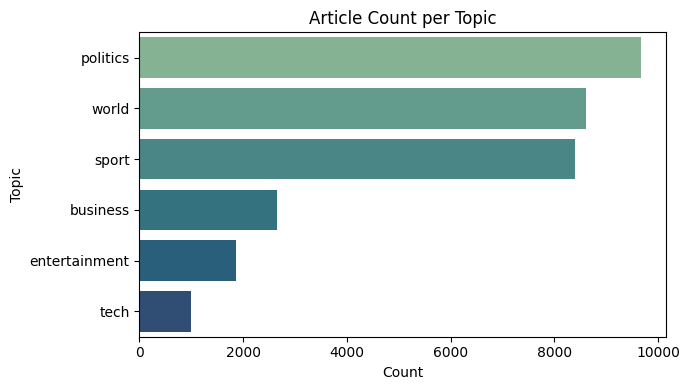

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.countplot(y=df_clf["label"], order=df_clf["label"].value_counts().index, palette="crest")
plt.title("Article Count per Topic")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


/tmp/ipython-input-4137323372.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="n_tokens", data=df_clf, palette="viridis")


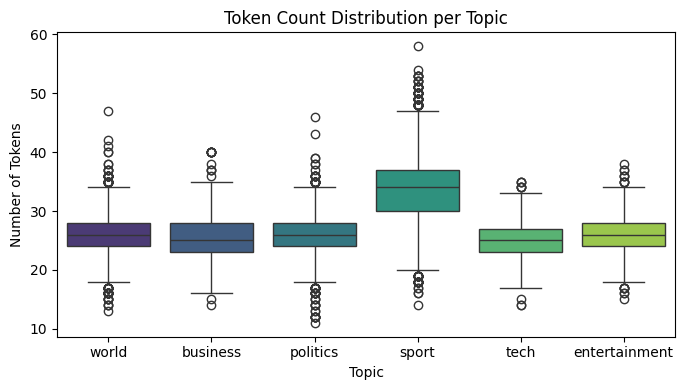

In [20]:
df_clf["n_tokens"] = df_clf["text"].str.split().str.len()

plt.figure(figsize=(7,4))
sns.boxplot(x="label", y="n_tokens", data=df_clf, palette="viridis")
plt.title("Token Count Distribution per Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()


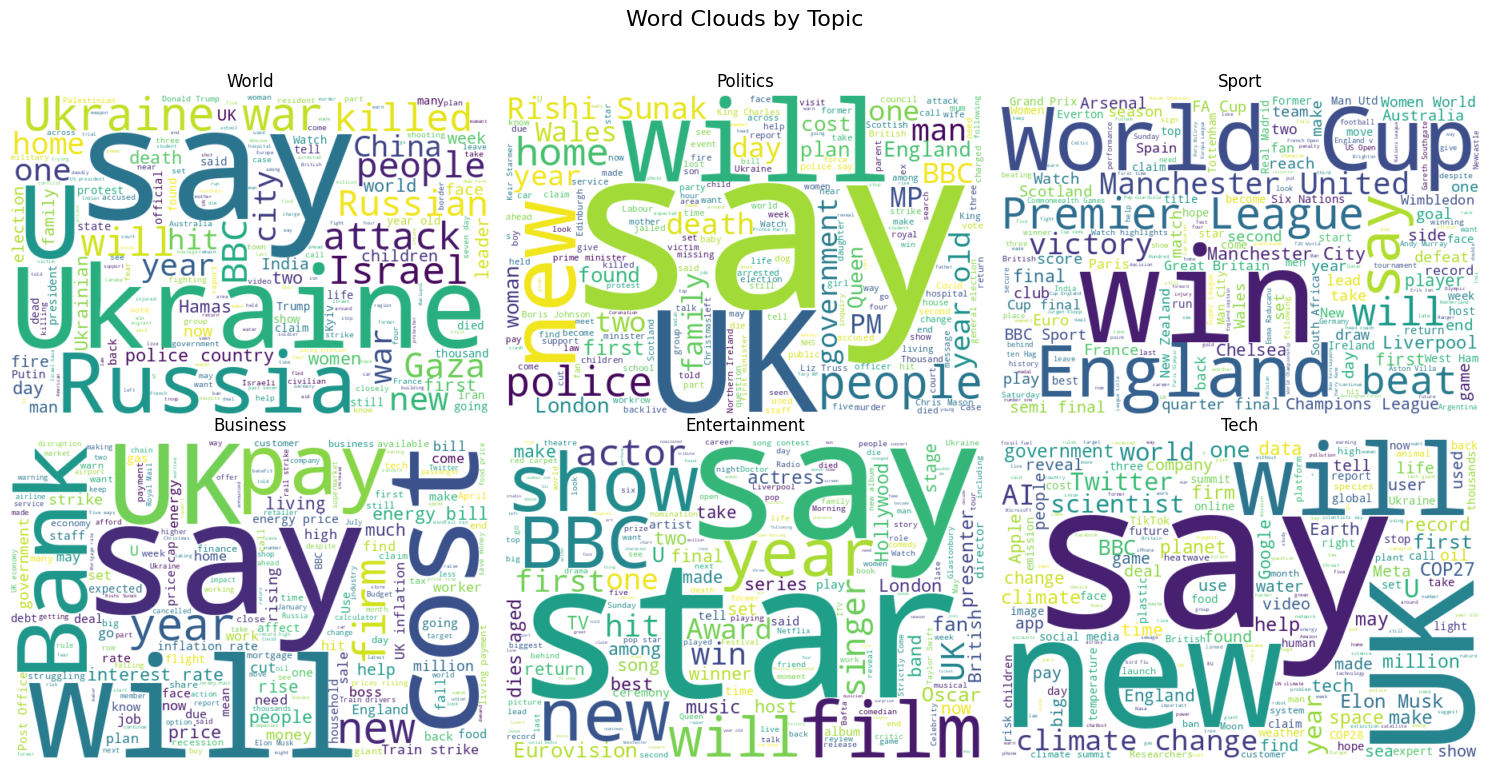

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,3, figsize=(15,8))
axes = axes.flatten()

for i, lab in enumerate(["world","politics","sport","business","entertainment","tech"]):
    text = " ".join(df_clf.loc[df_clf["label"]==lab, "text"].astype(str))
    wc = WordCloud(width=600, height=400, background_color="white", stopwords=None).generate(text)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(lab.capitalize())

plt.suptitle("Word Clouds by Topic", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


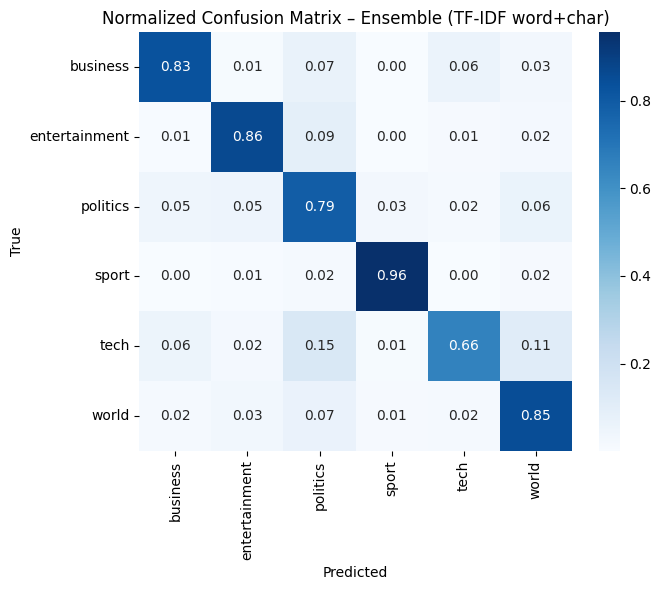

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, pred_ens, labels=labels, normalize="true")

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix – Ensemble (TF-IDF word+char)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


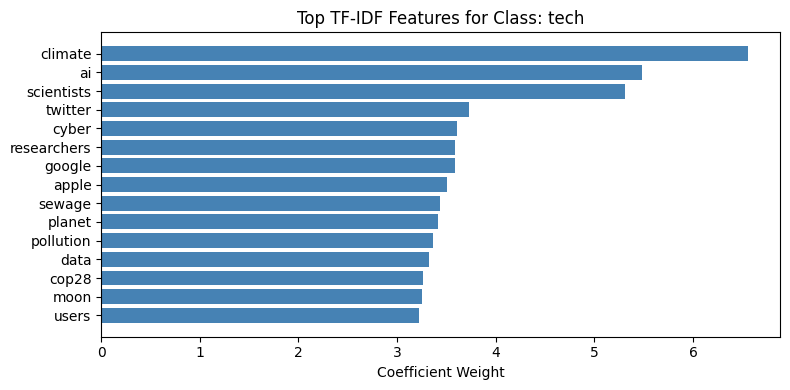

In [23]:
import pandas as pd
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())
class_index = list(clf.classes_).index("tech")
coefs = clf.coef_[class_index]
top = np.argsort(coefs)[-15:]

plt.figure(figsize=(8,4))
plt.barh(feature_names[top], coefs[top], color="steelblue")
plt.title("Top TF-IDF Features for Class: tech")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()


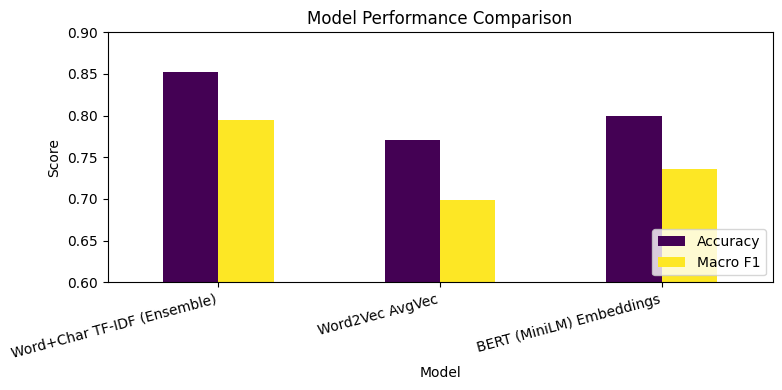

In [24]:
import pandas as pd

data = {
    "Model": ["Word+Char TF-IDF (Ensemble)", "Word2Vec AvgVec", "BERT (MiniLM) Embeddings"],
    "Accuracy": [0.8527, 0.7703, 0.8001],
    "Macro F1": [0.7951, 0.6983, 0.7360]
}

res_df = pd.DataFrame(data).set_index("Model")
res_df.plot(kind="bar", figsize=(8,4), colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=15, ha="right")
plt.ylim(0.6, 0.9)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


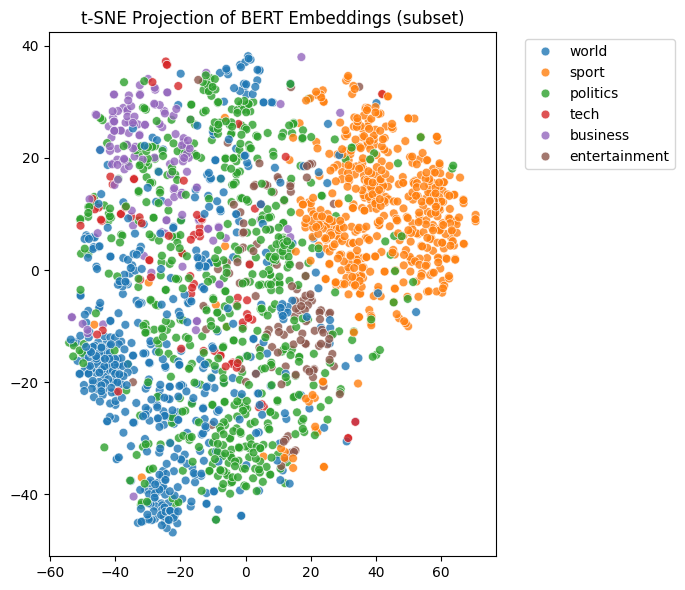

In [25]:
from sklearn.manifold import TSNE

# reduce BERT embeddings to 2D
tsne = TSNE(n_components=2, perplexity=40, random_state=42, n_iter=1000)
emb2d = tsne.fit_transform(Xva_bert[:2000])  # subset for speed
labs2d = y_val[:2000]

plt.figure(figsize=(7,6))
sns.scatterplot(x=emb2d[:,0], y=emb2d[:,1], hue=labs2d, palette="tab10", s=40, alpha=0.8)
plt.title("t-SNE Projection of BERT Embeddings (subset)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()
